In [1]:

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit import Aer, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from IPython.display import clear_output
from scipy.sparse.linalg import eigs
from scipy import sparse
import math

num_q = 10
J = 1
Delta = 1.5
List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

List_2 = []
op = ""
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

H = SparsePauliOp.sum([H1,H2])

# Ordering e.g. IIIIIIZZ is the measurement of Z gates on the first two qubits and so forth.

Hmat = Operator(H)
Hmat = sparse.csr_matrix(Hmat)

e, v = eigs(Hmat,k=20)
#e, v = LA.eig(Hmat)
min_index = np.argmin(e)
v_min = v[:,min_index]
ground_e = np.min(e)
print(H[-1])
print(np.min(e))
print(H.size)
print(H.paulis[0])


SparsePauliOp(['IIIIIIIIIX'],
              coeffs=[1.5+0.j])
(-16.535254946759267-9.532233011662484e-17j)
19
IIIIIIIIZZ


In [2]:


"""circuit construction"""

layer = 20
num_p = 2*layer

weights = ParameterVector("weight",num_p)


def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    for j in range(num_q):
        circ.ry(np.pi/2*3,j)
        
    for i in range(layer):
        
        for j in range(int(num_q/2)):
            circ.rzz(weights[2*i],2*j,2*j+1)
        for j in range(int(num_q/2)-1):
            circ.rzz(weights[2*i], 2*j+1, 2*j+2)
        for j in range(num_q):
            circ.rx(weights[2*i+1], j)
        
        
        
    return circ 


In [3]:

simulator = Aer.get_backend('aer_simulator')

def estimate_loss(WEIGHTS, SHOTS):
    estimate = 0
    qc = circuit_ex(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1
    for i in range(SHOTS):
        for j in range(num_q-1):
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1
    estimate = J*estimate/SHOTS
    
    estimate_1 = 0
    qc = circuit_ex(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    estimate_1 = Delta*estimate_1/SHOTS
    return estimate+estimate_1

def expectation_loss(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    return np.absolute(np.vdot(psi,v_min))**2

Loss and Fidelity and grad: -7.237118555262771 0.03170799293205755 75.94965552792067 0.004463506920444945


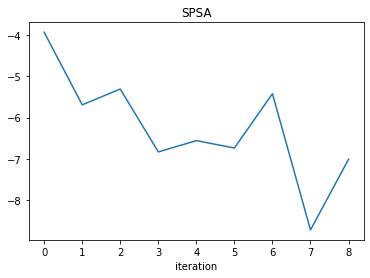

KeyboardInterrupt: 

In [7]:
"""optimization phase"""



"""initialization of weights"""
mat = scipy.io.loadmat('w0')
w0 = mat['w0']


initial_weights = np.ones(num_p) #np.ones(num_p)
#initial_weights[:10] = w0.flatten()

T = 1000
n_shot = 1000

alpha = 0.602
gamma = 0.101
c = 0.2

identity = np.identity(num_p)
num_results = 10
cost_mat = np.empty((0,T), int)
weight_mat = np.empty((0,T), int)
fidelity_mat = np.empty((0,T), int)
F = 0
iteration = 0
loss = 0 


# the following calibtration is from below 137 line in the page https://github.com/Qiskit/qiskit/blob/stable/0.17/qiskit/algorithms/optimizers/spsa.py

target_magnitude = 2 * np.pi / 10

steps = 25
avg_magnitudes = 0
for _ in range(steps):
            # compute the random directon
    delta = 2*np.round(np.random.uniform(0,1,num_p))-1
    init_plus = initial_weights+c*delta
    init_minus = initial_weights-c*delta
    diff_f = expectation_loss(init_plus) - expectation_loss(init_minus)

    avg_magnitudes += np.abs(diff_f / (2 * c))

avg_magnitudes /= steps

a_0 = target_magnitude / (avg_magnitudes**2)

for l in range(num_results):
    cost = []
    cost_f = []
    Weights = []
    weights = initial_weights
    iteration = 0
    while iteration < T:
        a = a_0/(iteration+1)**alpha
        iteration = iteration + 1
        c_iter = c/(iteration + 1)**gamma
        delta = 2*np.round(np.random.uniform(0,1,num_p))-1
        weightplus = weights+c_iter*delta
        weightminus = weights-c_iter*delta
        gradient = 1/(2*c_iter)*(estimate_loss(weightplus, n_shot) - estimate_loss(weightminus, n_shot))/delta
        weights = weights - a*gradient
        Weights.append(weights)
        F = fidelity(weights)
        loss = expectation_loss(weights)
        clear_output(wait=True)
        print('Loss and Fidelity and grad:',loss, fidelity(weights),np.linalg.norm(gradient), a)
        plt.plot(cost)
        plt.xlabel('iteration')
        plt.title('SPSA')
        plt.show()
        cost.append(loss.flatten())
        cost_f.append(F.flatten())    
    Cost = np.asarray(cost)
    WEIGHTS = np.asarray(Weights)
    FIDELITY = np.asarray(cost_f)
    cost_mat = np.append(cost_mat, np.transpose(Cost), axis = 0)
    weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis = 0)
    fidelity_mat = np.append(fidelity_mat, np.transpose(FIDELITY), axis = 0)
    
scipy.io.savemat('spsa_loss_3.mat', {'spsa_loss': cost_mat})
scipy.io.savemat('spsa_weight_3.mat', {'spsa_weight': weight_mat})
scipy.io.savemat('spsa_fidelity_3.mat', {'spsa_fidelity': fidelity_mat})


#plt.plot(cost)
#plt.title('GD')
#plt.xlabel('iteration')
#plt.show()
